# Intersection over Union
**Author**: Johannes S. Fischer

When training an object detection mode, you have surely stumbled across the *Intersection over Union*, in short **IoU**. In this short post, I will describe what it is and how to implement it in native Python. Furthermore, I will describe the implementation in Tensorflow Vector Operations, so that it can be efficiently used for measuring the accuracy of an object detection model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import time

def computeIoU(bbox1, bbox2):
    (x1, y1, w1, h1) = bbox1
    (x2, y2, w2, h2) = bbox2
    
    # Firstly, we calculate the areas of each box
    # by multiplying its height with its width.
    area1 = w1 * h1
    area2 = w2 * h2
    
    # Secondly, we determine the intersection
    # rectangle. For that, we try to find the
    # corner points (top-left and bottom-right)
    # of the intersection rectangle.
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)
    
    # From the two corner points we compute the
    # width and height.
    inter_w = max(0, inter_x2 - inter_x1) 
    inter_h = max(0, inter_y2 - inter_y1)
        
    # If the width or height are equal or less than zero
    # the boxes do not overlap. Hence, the IoU equals 0.
    if inter_w <= 0 or inter_h <= 0:
        return 0.0
    # Otherwise, return the IoU (intersection area divided
    # by the union)
    else:
        inter_area = inter_w * inter_h
        return inter_area / float(area1 + area2 - inter_area)

## What is the IoU?

The IoU is a metric for measuring the accuracy of an object detection model. Imagine you have two bounding boxes, one predicted bounding box and one ground truth bounding box, and you want some indication of how good the prediction is. That's where the Intersection over Union comes into place. 

Shortly described: The Intersection over Union measures the overlap between the two bounding boxes. A resulting value of 1 indicates perfect prediction, while lower values suggest a poor prediction accuracy.

The figure below shows two bounding boxes (green and blue). In the beginning there is no overlap, hence, the Intersection over Union equals 0 (bad prediction). But as the overlap increases, also the IoU increases, until the IoU is 1 for two bounding boxes that are congruent (perfect prediction).

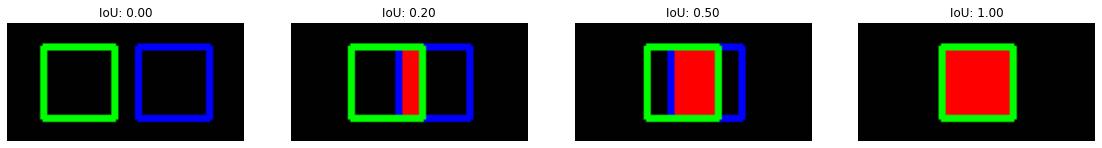

In [2]:
plt.figure(figsize=(50,20))

x1s = [15, 25, 30, 35]
x2s = [55, 45, 40, 35]
for i in range(4):
    img = np.ones((50, 100, 3), dtype="uint8")
    # rect 1
    x1, y1, w1, h1 = x1s[i], 10, 30, 30
    # rect 2
    x2, y2, w2, h2 = x2s[i], 10, 30, 30
    # intersection
    inter_x1 = max(x1, x2); inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2); inter_y2 = min(y1 + h1, y2 + h2)
    inter_w = max(0, inter_x2 - inter_x1) 
    inter_h = max(0, inter_y2 - inter_y1)
    if inter_w * inter_h > 0:
        cv2.rectangle(img, (inter_x1,inter_y1), (inter_x2-1, inter_y2-1), (255, 0, 0), -1)
    
    cv2.rectangle(img, (x2,y2), (x2+w2,y2+h2), (0, 0, 255), 2)
    cv2.rectangle(img, (x1,y1), (x1+w1,y1+h1), (0, 255, 0), 2)
    
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    iou = computeIoU((x2, y2, w2, h2), (x1, y1, w1, h1))
    plt.title('IoU: %.2f' % iou)
    plt.imshow(img)

plt.savefig('./iou-examples.png', dpi=300, bbox_inches='tight')
plt.show()

## Intuitive Example


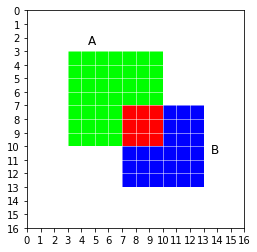

In [3]:
field_size = 16

img = np.ones((field_size, field_size, 3), dtype="uint8") * 255

# rect 1
x1, y1, w1, h1 = 3, 3, 7, 7
cv2.rectangle(img, (x1,y1), (x1+w1-1,y1+h1-1), (0, 255, 0), -1)

# rect 2
x2, y2, w2, h2 = 7, 7, 6, 6
cv2.rectangle(img, (x2,y2), (x2+w2-1,y2+h2-1), (0, 0, 255), -1)

# intersection
x3, y3, w3, h3 = 7, 7, 3, 3
cv2.rectangle(img, (x3,y3), (x3+w3-1,y3+h3-1), (255, 0, 0), -1)

# plot image
plt.imshow(img, interpolation="nearest")
plt.annotate("A", (4, 2), color="black", size="large")
plt.annotate("B", (13, 10), color="black", size="large")
ax = plt.gca()
ax.set_xticks(np.arange(-.5, field_size, 1))
ax.set_yticks(np.arange(-.5, field_size, 1))
ax.set_xticklabels(np.arange(0, field_size+1, 1))
ax.set_yticklabels(np.arange(0, field_size+1, 1))
ax.grid(color='white', linestyle='-', linewidth=0.5)

plt.savefig('./simple-example.png', dpi=300, bbox_inches='tight')

plt.show()

For a more intuitive understanding let's have a look at an example. In the picture below two rectangles A (green) and B (blue) are displayed. Rectangle A has a width and height of 7, while B has a width and height of 6 (both in pixels).

The IoU can now be described as the area of overlap divided by the area of the union. So: $IoU = \frac{A \cap B}{A \cup B}$.

For our concrete example the intersecting area (red) is

$$area(A \cap B) = 3 \cdot 3 = 9$$

The area of A (green) is

$$area(A) = 7 \cdot 7 = 49$$

and the area of B (blue) is

$$area(B) = 6 \cdot 6 = 36.$$

The union of A and B can be computed as 

$$area(A \cup B) = area(A) + area(B) - area(intersection) = 49 + 36 - 9 = 76.$$

Now we can compute the Intersection over Union by dividing the intersection $(A \cap B)$ through the union of A and B, which yields an IoU of

$$IoU = \frac{A \cap B}{A \cup B} = \frac{9}{76} = 0.1184 \approx 11.8\%$$

## Naive Implementation

Now let's put everything what we've done so far in a function that get's two bounding boxes as input and returns the Intersection over Union. The bounding boxes have the form $(x, y, w, h)$, with $x$ and $y$ being the coordinates of the top-left corner, and $w$ and $h$ being the width and height of the box, respectively.

In [4]:
def computeIoU(bbox1, bbox2):
    (x1, y1, w1, h1) = bbox1
    (x2, y2, w2, h2) = bbox2
    
    # Firstly, we calculate the areas of each box
    # by multiplying its height with its width.
    area1 = w1 * h1
    area2 = w2 * h2
    
    # Secondly, we determine the intersection
    # rectangle. For that, we try to find the
    # corner points (top-left and bottom-right)
    # of the intersection rectangle.
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)
    
    # From the two corner points we compute the
    # width and height.
    inter_w = max(0, inter_x2 - inter_x1) 
    inter_h = max(0, inter_y2 - inter_y1)
        
    # If the width or height are equal or less than zero
    # the boxes do not overlap. Hence, the IoU equals 0.
    if inter_w <= 0 or inter_h <= 0:
        return 0.0
    # Otherwise, return the IoU (intersection area divided
    # by the union)
    else:
        inter_area = inter_w * inter_h
        return inter_area / float(area1 + area2 - inter_area)

Let's compute the IoU for a few examples:

In [5]:
# example from above
iou = computeIoU((3, 3, 7, 7), (7, 7, 6, 6))
print("IoU Example: %.4f" % iou)

# congruent bounding boxes
iou = computeIoU((3, 4, 10, 10), (3, 4, 10, 10))
print("IoU Congruent: %.4f" % iou)

# non overlapping bounding boxes
iou = computeIoU((2, 2, 6, 6), (10, 10, 5, 5))
print("IoU non Overlapping: %.4f" % iou)

IoU Example: 0.1184
IoU Congruent: 1.0000
IoU non Overlapping: 0.0000


In [6]:
""" Output
IoU Example: 0.1184
IoU Congruent: 1.0000
IoU non Overlapping: 0.0000
"""

' Output\nIoU Example: 0.1184\nIoU Congruent: 1.0000\nIoU non Overlapping: 0.0000\n'

Perfect, the function works as expected. ;)

## IoU for Tensorflow

In machine learning it is common to measure the accuracy for a whole batch and not only for a single example. Hence, we need another function that can compute the Intersection over Union for a batch, in order to use it as a metric in Tensorflow. The function expects two arrays of bounding boxes (ground truth & predicted), each with the dimension $(n, 4)$ with $n$ being the batch-size.

#### Naive Implementation

For the naive implementation we just iterate through all samples of the batch, compute the IoU with our function, and append it to an array.

In [7]:
def IoU_naive(y_true, y_pred):
    batch_size = y_true.shape[0]
    
    # array to store all IoU values
    all_IoUs = []
    for i in range(batch_size):
        
        # compute IoU with previously defined function
        iou = computeIoU(y_true[i], y_pred[i])
        
        # and append it to the array
        all_IoUs.append( iou )
    
    return np.asarray(all_IoUs)

This naive implementation does the job. However, it is fairly slow...

In [8]:
# random bounding boxes
y_true = np.random.randint(10, 255, (100000, 4))
y_pred = np.random.randint(10, 255, (100000, 4))

t0 = time.time()
_ = IoU_naive(y_true, y_pred)
print("Naive: %.5f seconds" % (time.time() - t0))

Naive: 0.86247 seconds


For a batch-size of 100.000 samples, the function takes about 0.9 seconds. This can be done faster!

#### Tensorflow Implementation

The more appropriate computation way in machine learning is to use vector operations, e.g. using tensorflow.

In [9]:
def IoU(y_true, y_pred):
    # cast type of bounding boxes to avoid running
    # into a type-error in tensorflow
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # store all x's, y's, w's, and h's for the
    # predicted and ground truth bounding boxes
    x1, y1, w1, h1 = y_true[:, 0], y_true[:, 1], y_true[:, 2], y_true[:, 3]
    x2, y2, w2, h2 = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]
    
    # compute bounding box areas
    areas1 = tf.multiply( w1, h1 )
    areas2 = tf.multiply( w2, h2 )
    
    # intersection rectangle coordinates (top-left, bottom-right)
    inter_x1 = tf.maximum(x1, x2)
    inter_y1 = tf.maximum(y1, y2)
    inter_x2 = tf.minimum(x1 + w1, x2 + w2)
    inter_y2 = tf.minimum(y1 + h1, y2 + h2)
    
    # intersection rectangles width, height, and finally area
    inter_w = tf.maximum( 0.0, inter_x2 - inter_x1 )
    inter_h = tf.maximum( 0.0, inter_y2 - inter_y1 )
    inter_areas = inter_w * inter_h
    
    # compute IoUs for all bounding box pairs, if their width
    # and height are greater than 0 (otherwise return 0 as IoU)
    bool_vec = tf.math.logical_or(tf.math.less_equal(inter_w, 0),
                                tf.math.less_equal(inter_h, 0))
    ious = tf.where(bool_vec, tf.cast(0, tf.float32),
                    inter_areas / (areas1 + areas2 - inter_areas) )
    
    return ious

In [20]:
# random bounding boxes
y_true = np.random.randint(10, 255, (100000, 4))
y_pred = np.random.randint(10, 255, (100000, 4))

t0 = time.time()
_ = IoU(y_true, y_pred)
print("Tensorflow: %.5f seconds" % (time.time() - t0))

Tensorflow: 0.00600 seconds


The Tensorflow implementation just took about 0.007 seconds. Much faster!

For a better comparison, I plotted the computation time depending on the batch size in the figure below.

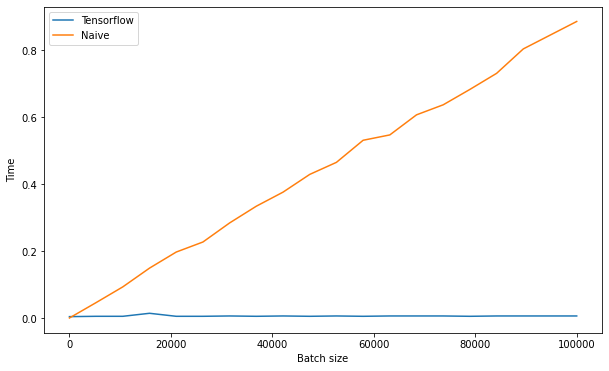

Wall time: 9.52 s


In [11]:
%%time
linspace = np.linspace(0, 100000, 20, dtype=int)

y_true = np.random.randint(10, 255, (np.max(linspace), 4))
y_pred = np.random.randint(10, 255, (np.max(linspace), 4))

results = {'slow': [], 'fast': []}
for i in linspace:
    t0 = time.time()
    slow = IoU_naive(y_true[:i], y_pred[:i])
    results['slow'].append(time.time() - t0)
    
    t0 = time.time()
    fast = IoU(y_true[:i], y_pred[:i])
    results['fast'].append(time.time() - t0)
    
plt.figure(figsize=(10,6))
plt.plot(linspace, results['fast'], label="Tensorflow")
plt.plot(linspace, results['slow'], label="Naive")
plt.xlabel('Batch size'); plt.ylabel('Time')
plt.legend()
plt.savefig('comparison-naive-tf.png', dpi=300, bbox_inches='tight')
plt.show()

Here one can see particularly well that with increasing $n$ the computation time increases linearly for the naive implementation. In contrast, the Tensorflow implementation just requires constant time.

### Using the IoU as metric for the Tensorflow model

The IoU function can now be used to evaluate an object localization model. For demonstration purposes, I created a simple toy dataset with rectangles displayed on neutral background (as described in this post).

### Dataset

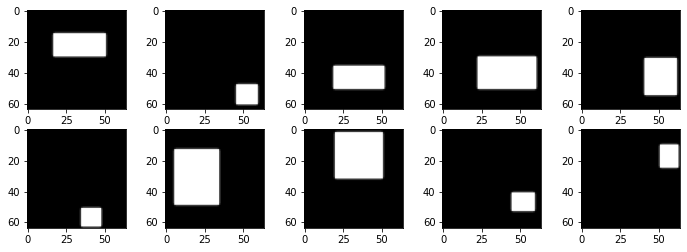

In [12]:
from sklearn.model_selection import train_test_split

# dataset
image_size = 64
min_size = 12

np.random.seed(2802)

""" DATA GENERATION"""
X, Y = [], []
for sample in range(15000):
    # create image
    img = np.zeros((image_size, image_size, 1), dtype="uint8")
    
    # get random x and y coordinate
    x, y = np.random.randint(0, image_size - min_size, 2)
    # get random width and height
    w = np.random.randint(min_size, image_size - x)
    h = np.random.randint(min_size, image_size - y)
    
    # assign target vector to sample
    Y.append([x, y, w, h])

    # draw rectangle on image
    cv2.rectangle(img, (x,y), (x+w-1,y+h-1), 255, -1,
                  lineType=cv2.LINE_AA)
    X.append(img)

X = np.asarray(X)
Y = np.asarray(Y).astype(np.float32)

""" VISUALIZATION """
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i], "gray")
    
plt.savefig('./data-examples.png', dpi=300, bbox_inches='tight')
plt.show()

""" PREPROCESSING """
# normalize and center image data
X = (X.astype("float32") / 255 ) - 0.5

# split into training, validation, and test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, 
                                                  test_size=0.2, random_state=29)

### Model
The model is kept simple, with alternating convolutional and max-pooling layers. The most important part comes at the compilation of the model, where you can pass the IoU function as metric.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Flatten, Dropout, Activation

model = Sequential([
    Conv2D( 16, kernel_size=3, activation='relu',
           input_shape=(image_size, image_size, 1)),
    Conv2D( 16, kernel_size=3, activation='relu'),
    MaxPooling2D( pool_size=2),
    Conv2D( 32, kernel_size=3, activation='relu'),
    Conv2D( 32, kernel_size=3, activation='relu'),
    MaxPooling2D( pool_size=2),
    Flatten(),
    Dropout(0.5),
    Dense(4)
])

model.compile("adam", loss='mse', metrics=IoU)

#### Training the model
The Intersection over Union is now used as metric and during training, the training and validation IoU is displayed. 

In [14]:
%%time

epochs = 25
history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    validation_data=(X_val, Y_val))

Epoch 1/25
300/300 [==============================] - 7s 14ms/step - loss: 101.0867 - IoU: 0.3906 - val_loss: 39.8459 - val_IoU: 0.5157
Epoch 2/25
300/300 [==============================] - 4s 14ms/step - loss: 21.8482 - IoU: 0.5650 - val_loss: 8.1091 - val_IoU: 0.6994
Epoch 3/25
300/300 [==============================] - 4s 14ms/step - loss: 11.4204 - IoU: 0.6299 - val_loss: 4.7726 - val_IoU: 0.7522
Epoch 4/25
300/300 [==============================] - 4s 14ms/step - loss: 8.8642 - IoU: 0.6574 - val_loss: 3.5340 - val_IoU: 0.7664
Epoch 5/25
300/300 [==============================] - 4s 13ms/step - loss: 7.8186 - IoU: 0.6692 - val_loss: 2.9940 - val_IoU: 0.7831
Epoch 6/25
300/300 [==============================] - 4s 14ms/step - loss: 7.0919 - IoU: 0.6793 - val_loss: 2.5761 - val_IoU: 0.7975
Epoch 7/25
300/300 [==============================] - 4s 14ms/step - loss: 6.3143 - IoU: 0.6924 - val_loss: 2.3728 - val_IoU: 0.7993
Epoch 8/25
300/300 [==============================] - 4s 14ms/st

#### Results

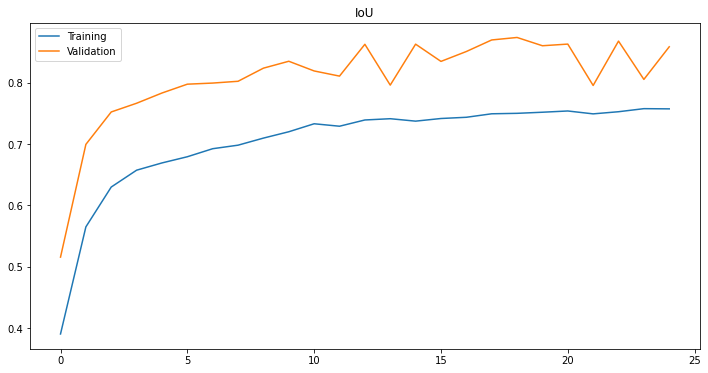

In [15]:
plt.figure(figsize=(12,6))

plt.plot(np.arange(epochs), history.history['IoU'], label='Training')
plt.plot(np.arange(epochs), history.history['val_IoU'], label='Validation')
plt.title("IoU"); plt.legend()

plt.savefig('model-results.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# predict test set
preds = model.predict(X_test)

# compute mean IoU
print("mean IoU: %.2f%%" % (np.mean(IoU(Y_test, preds)) * 100))

mean IoU: 86.26%


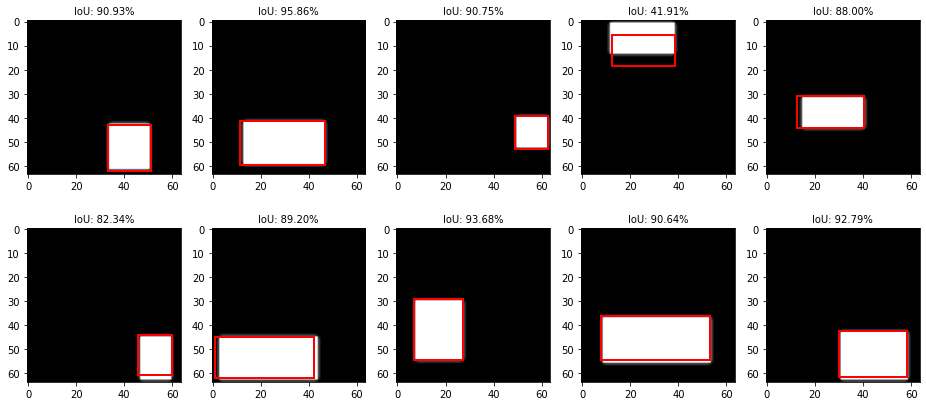

In [17]:
import matplotlib.patches as patches

plt.figure(figsize=(16, 7))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(X_test[i], "gray")
    x, y, w, h = preds[i]
    rect_pred = patches.Rectangle((x-0.5, y-0.5), w, h,
                                  linewidth=2, edgecolor="r", facecolor='none')
    ax.add_patch(rect_pred)
    plt.title("IoU: %.2f%%" % (computeIoU(preds[i], Y_test[i])*100), fontsize=10)

plt.savefig('./IoU-regression-example.png', dpi=300, bbox_inches='tight')
plt.show()

---

In [18]:
y_true = np.array([[1.0, 1.0, 8.0, 8.0],
                   [4.0, 4.0, 22.0, 22.0],
                   [2.0, 2.0, 22.0, 22.0],
                   [2.0, 2.0, 22.0, 22.0]], dtype="float64")
y_pred = np.array([[11.0, 11.0, 9.0, 9.0],
                   [2.0, 2.0, 18.0, 18.0],
                   [5.0, 5.0, 25.0, 25.0],
                   [2.0, 2.0, 22.0, 22.0]], dtype="float64")

print( np.array( IoU(y_true, y_pred) ))
print( IoU_naive(y_true, y_pred) )

[0.         0.46376812 0.48262033 1.        ]
[0.         0.46376812 0.48262032 1.        ]


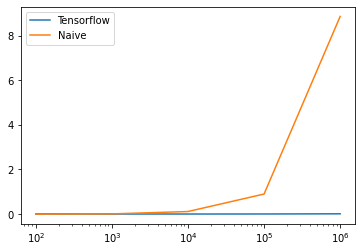

Wall time: 10.8 s


In [19]:
%%time
logspace = np.logspace(2, 6, 5, dtype=int)

y_true = np.random.randint(10, 255, (np.max(logspace), 4))
y_pred = np.random.randint(10, 255, (np.max(logspace), 4))

results = {'slow': [], 'fast': []}
for i in logspace:    
    t0 = time.time()
    _ = IoU_naive(y_true[:i], y_pred[:i])
    results['slow'].append(time.time() - t0)
    
    t0 = time.time()
    _ = IoU(y_true[:i], y_pred[:i])
    results['fast'].append(time.time() - t0)
    
plt.xscale('log')
plt.plot(logspace, results['fast'], label="Tensorflow")
plt.plot(logspace, results['slow'], label="Naive")
plt.legend(); plt.show()

---